# LSA - Latent Semantic Analysis (Phân tích ngữ nghĩa tiềm ẩn)

- LSA là 1 phương pháp chủ yếu sử dụng trong NLP. LSA được sử dụng để tìm ra các “chủ đề ẩn” trong Corpus, từ đó tạo ra một không gian ngữ nghĩa tiềm ẩn (Latent Semantic Space) và chiếu các vector văn bản và vector token lên không gian đó. Sự khác biệt so với PCA: LSA được thiết kế để hoạt động trên các dạng ma trận từ ngữ - văn bản (TDM) như đầu ra của TF-IDF. LSA không căn giữa dữ liệu đầu văn như PCA. LSA sử dụng khai triển kì dị rút gọn (Truncated SVD) là cơ chế chính cho việc giảm chiều dữ liệu.
- Vậy, với ma trận TF-IDF gốc, ta có thể hiểu mỗi vector văn bản là 1 sample, và mỗi vector token là 1 đặc trưng, đo độ “quan trọng” của token đó với văn bản cụ thể đó. Điều này dẫn tới không gian lớn và thưa. LSA sẽ giảm chiều của không gian đặc trưng đó từ các token riêng biệt xuống các “chủ đề ẩn” ở đó ma trận TDM sẽ dày hơn và nhỏ hơn, không chỉ giảm tính toán mà còn giúp ta có thể khám phá các “chủ đề ẩn” này.

### Khai triển kì dị rút gọn
Giả sử ma trận $ W \in \mathbb{R}^{n \times N} $ là ma trận TF-IDF gốc của chúng ta, trong đó có $ n $ hàng đại diện cho các vector token và $ N $ cột đại diện cho các vector văn bản, khi đó khai triển kì dị rút gọn được định nghĩa như sau:

$$ W \approx W_k = U_k \Sigma_k V_k^T $$

Trong đó:
- $ k $ là số chủ đề tiềm ẩn ta mong muốn tìm.
- $ W_k \in \mathbb{R}^{n \times N} $ là một ma trận xấp xỉ thiểu hạng của ma trận gốc $ W $.
- $ U_k \in \mathbb{R}^{n \times k} $ là ma trận thể hiện MQH token - topic, theo hàng.
- $ \Sigma_k \in \mathbb{R}^{k \times k} $ là ma trận chéo chứa các giá trị kì dị, hay độ quan trọng của mỗi topic theo thứ tự giảm dần.
- $ V_k^T \in \mathbb{R}^{n \times N} $ là ma trận thể hiện MQH doc. - topic, theo cột.

### Thể hiện các token và văn bản trong không gian tiềm ẩn

- LSA sẽ tạo ra không gian tiềm ẩn mà trong đó các chủ đề tiềm ẩn được coi là các chiều.
- Sử dụng các hàng của $ U_k $, ta có thể biểu diễn các token trong không gian tiềm ẩn này.
- Sử dụng các cột của $ D_k = \Sigma_k V_k^T \in \mathbb{R}^{k \times N} $, ta có thể biểu diễn các văn bản trong không gian tiềm ẩn này
- Kết hợp cả biểu diễn token và văn bản trên cùng 1 biểu đồ, ta thu được Biplot.



In [6]:
# Nhập thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Đọc bộ dữ liệu
corpus = pd.read_csv('data/cleaned_mhc.csv')

In [7]:
n_topics = 2
n_top_words = 15
n_top_docs = 15

vectorizer = TfidfVectorizer(max_features=3500)
svd_model = TruncatedSVD(n_components=n_topics, random_state=42)

X_cleaned_tfidf = vectorizer.fit_transform(corpus['text'])
X_latent = svd_model.fit_transform(X_cleaned_tfidf)

def display_topics_and_docs(model, feature_names, num_top_words, X_latent, n_top_docs):
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        print(f"\nTopic {idx + 1}: {', '.join(top_words)}")
        
        top_doc_indices = np.argsort(X_latent[:, idx])[:-n_top_docs - 1:-1]
        print(f"Top {n_top_docs} documents for Topic {idx + 1}:")
        for doc_idx in top_doc_indices:
            label = corpus['label'].iloc[doc_idx]
            text_preview = corpus['text'].iloc[doc_idx][:100]
            print(f"Class {label}: {text_preview} ...")

print("\nTop topics and their representative documents in Cleaned Corpus:")
display_topics_and_docs(svd_model, vectorizer.get_feature_names_out(), n_top_words, X_latent, n_top_docs)


Top topics and their representative documents in Cleaned Corpus:

Topic 1: im, want, like, feel, know, life, ive, get, cant, dont, friend, time, people, even, one
Top 15 documents for Topic 1:
Class 1: yet another fucking post even know happened feel bad swear mood swing easily distinct one closest fr ...
Class 1: fuck made post talked situation little friend leaving college parent really like care long im fed re ...
Class 1: gonna long rant feel free skip want feel fucking hopeless wrote redflag note month ago parent found  ...
Class 1: actually feel alright thats past year going quite well outside ive started leaving house pretty much ...
Class 1: hopeless reddit im longtime lurker need help family friend connected avenue communication feel comfo ...
Class 1: wanting kill since grade im scared please listen know anymore im last straw everything im going give ...
Class 1: understand life know im posting feel ashamed im posting want die want live feel like ive never reall ...
Class 1:

In [8]:
from IPython.display import display, HTML

def style_df_with_highlights(df, highlight_terms):
    def highlight_words(val):
        if isinstance(val, str) and val.upper() in [term.upper() for term in highlight_terms]:
            return 'background-color: #800080'
        return ''
    
    return df.style.applymap(highlight_words)

def display_topics_tabular(model, feature_names, num_top_words, highlight_terms, words_per_row=15):
    topic_dfs = []
    
    for idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        top_words = [word.upper() if word in highlight_terms else word for word in top_words]
        
        num_rows = (len(top_words) + words_per_row - 1) // words_per_row
        
        rows = []
        for row in range(num_rows):
            start_idx = row * words_per_row
            end_idx = min(start_idx + words_per_row, len(top_words))
            row_words = top_words[start_idx:end_idx]
            row_words.extend([''] * (words_per_row - len(row_words)))
            rows.append(row_words)
        
        df = pd.DataFrame(
            rows,
            columns=[f'Token_{i+1}' for i in range(words_per_row)]
        )
        
        df.index = [f'Row_{i+1}' for i in range(len(df))]
        
        topic_dfs.append((idx + 1, df))

    for topic_num, df in topic_dfs:
        print(f"\nTopic {topic_num}")
        
        styled_df = style_df_with_highlights(df, highlight_terms)
        
        display(styled_df)
        print("\n")

highlight_terms = ['suicidal', 'depression', 'suicide', 'kill', 'myself', 'die',
                   'died', 'pain', 'sad', 'help', 'sorry', 'anxiety', 'therapy',
                   'suffering', 'killing', 'pill', 'depressed', 'death', 'cry', 'redflag', 'tired',
                   'movie', 'film', 'character', 'story', 'actor', 'performance', 'show',
                   'plot', 'acting', 'scene', 'watch', 'seen', 'funny', 'dvd', 'drama', 
		   'dialouge', 'entertaining', 'hollywood', 'humor', 'star', 'horror', 'series',
		   'genre', 'production', 'cinema', 'effect', 'audience', 'picture', 'actress']

n_topics = 3
n_top_words = 195
svd_model = TruncatedSVD(n_components=n_topics, random_state=42)

X_cleaned_tfidf = vectorizer.fit_transform(corpus['text'])
svd_model.fit(X_cleaned_tfidf)
print("\nTop topics in Corpus:")
display_topics_tabular(svd_model, vectorizer.get_feature_names_out(), n_top_words, highlight_terms)


Top topics in Corpus:

Topic 1


,Token_1,Token_2,Token_3,Token_4,Token_5,Token_6,Token_7,Token_8,Token_9,Token_10,Token_11,Token_12,Token_13,Token_14,Token_15
Row_1,im,want,like,feel,know,life,ive,get,cant,dont,friend,time,people,even,one
Row_2,really,year,would,think,thing,day,going,go,HELP,never,make,much,anymore,fucking,thought
Row_3,way,good,someone,anything,DIE,need,end,talk,better,everything,hate,love,nothing,KILL,family
Row_4,live,see,could,always,anyone,feeling,school,care,still,say,something,every,got,back,work
Row_5,REDFLAG,right,ill,shit,keep,everyone,ever,last,take,bad,TIRED,tell,job,point,happy
Row_6,parent,try,person,since,tried,month,getting,alone,PAIN,reason,also,told,find,fuck,long
Row_7,wish,trying,give,lot,around,stop,DEPRESSION,away,done,girl,thats,SUICIDAL,hurt,week,hard
Row_8,made,living,enough,best,else,well,worse,guy,MOVIE,maybe,world,first,said,many,come
Row_9,please,hope,sure,ago,mom,DEPRESSED,thinking,wanted,scared,post,actually,look,today,felt,without
Row_10,lost,night,let,problem,CRY,probably,old,FILM,SAD,cannot,started,left,though,home,past





Topic 2


,Token_1,Token_2,Token_3,Token_4,Token_5,Token_6,Token_7,Token_8,Token_9,Token_10,Token_11,Token_12,Token_13,Token_14,Token_15
Row_1,MOVIE,FILM,one,CHARACTER,great,STORY,good,SCENE,well,see,also,first,time,SEEN,WATCH
Row_2,SHOW,best,would,ACTOR,PERFORMANCE,love,many,PLOT,FUNNY,ACTING,made,little,cast,role,saw
Row_3,man,two,make,comedy,watching,part,play,lot,music,director,new,woman,real,quite,action
Row_4,excellent,fun,girl,look,fan,could,come,interesting,young,really,guy,DVD,like,must,beautiful
Row_5,year,people,HORROR,wonderful,played,may,STAR,big,got,war,however,way,say,still,original
Row_6,although,perfect,recommend,old,find,american,liked,song,though,especially,SERIES,ever,bit,watched,classic
Row_7,true,moment,fact,said,line,favorite,enjoyed,another,thing,kid,work,different,found,AUDIENCE,pretty
Row_8,give,amazing,viewer,child,screen,back,shot,definitely,main,remember,CINEMA,EFFECT,john,book,course
Row_9,HOLLYWOOD,game,script,later,seeing,set,nice,highly,version,HUMOR,enjoy,men,video,something,along
Row_10,together,PICTURE,father,ENTERTAINING,DRAMA,kind,three,black,take,much,special,boy,simply,based,name





Topic 3


,Token_1,Token_2,Token_3,Token_4,Token_5,Token_6,Token_7,Token_8,Token_9,Token_10,Token_11,Token_12,Token_13,Token_14,Token_15
Row_1,im,MOVIE,FILM,gonna,ive,going,TIRED,cant,SORRY,bored,ill,CHARACTER,fucking,great,done
Row_2,STORY,guy,wanna,school,SCENE,well,scared,girl,good,thats,WATCH,pretty,play,sure,class
Row_3,SEEN,ACTOR,first,got,sick,tonight,probably,PERFORMANCE,FUNNY,fuck,game,kinda,PLOT,man,reddit
Row_4,also,looking,watching,post,cast,ready,ACTING,chat,job,SHOW,music,one,best,saw,new
Row_5,comedy,bit,lol,director,fan,role,old,hour,posting,boy,two,excellent,hey,DVD,whats
Row_6,favorite,goodbye,dad,fun,HORROR,test,yeah,yall,set,interesting,high,grade,STAR,song,gay
Row_7,played,trying,american,little,bye,next,minute,cause,soon,teacher,original,wait,luck,nervous,tomorrow
Row_8,young,war,playing,classic,recommend,guess,although,video,quite,must,screen,watched,ENTERTAINING,wonderful,see
Row_9,lazy,finally,version,book,cool,glad,loser,final,script,shit,ugly,john,highly,viewer,piece
Row_10,action,buy,failing,today,joke,comment,CINEMA,AUDIENCE,age,HOLLYWOOD,house,writing,line,failure,hilarious


### Các Scripts sử dụng cho việc trực quan hóa
- Quan sát các văn bản trong không gian 3 chiều tìm bởi LSA: `scripts/density_class_3d.py`.
- Trực quan độ dày của 2 lớp trên không gian 2 chiều tìm bởi LSA: `scripts/density_class.py`.
- Biplot 3 chiều động với package `plotly`: `scripts/term_document_plotly.py`.
- Biplot 2 chiều với các token được chọn lọc: `scripts/density_tdm_1.py`.
- Phân tích Cosine Similarity: `scripts/similarity_lsa.py`.
- Phân tích Explained Variance: `scripts/explained_variance.py`.


Label Distribution:
label
1    12648
0    10592
Name: count, dtype: int64


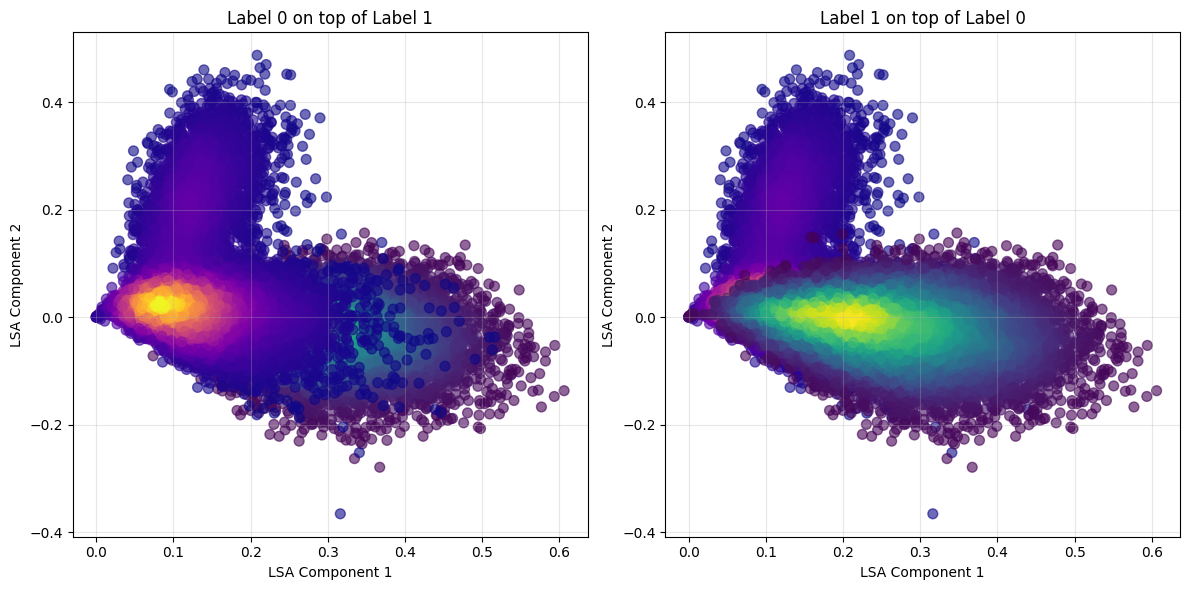

In [10]:
from scipy.stats import gaussian_kde

tfidf = TfidfVectorizer(max_features=3500)
tfidf_matrix = tfidf.fit_transform(corpus['text'])

lsa = TruncatedSVD(n_components=2, random_state=42)
doc_coords = lsa.fit_transform(tfidf_matrix)

labels = corpus['label']

def create_density_plots(doc_coords, labels):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    colors = ['viridis', 'plasma']

    mask0 = labels == 1
    mask1 = labels == 0

    label0_points = doc_coords[mask0]
    label1_points = doc_coords[mask1]

    xy0 = np.vstack([label0_points[:, 0], label0_points[:, 1]])
    density0 = gaussian_kde(xy0)(xy0)
    density0 = (density0 - density0.min()) / (density0.max() - density0.min())

    xy1 = np.vstack([label1_points[:, 0], label1_points[:, 1]])
    density1 = gaussian_kde(xy1)(xy1)
    density1 = (density1 - density1.min()) / (density1.max() - density1.min())

    axs[0].scatter(
        label0_points[:, 0],
        label0_points[:, 1],
        c=density0,
        cmap=colors[0],
        s=50,
        alpha=0.6
    )
    axs[0].scatter(
        label1_points[:, 0],
        label1_points[:, 1],
        c=density1,
        cmap=colors[1],
        s=50,
        alpha=0.6
    )
    axs[0].set_title('Label 0 on top of Label 1')
    axs[0].grid(True, alpha=0.3)

    axs[1].scatter(
        label1_points[:, 0],
        label1_points[:, 1],
        c=density1,
        cmap=colors[1],
        s=50,
        alpha=0.6
    )
    axs[1].scatter(
        label0_points[:, 0],
        label0_points[:, 1],
        c=density0,
        cmap=colors[0],
        s=50,
        alpha=0.6
    )
    axs[1].set_title('Label 1 on top of Label 0')
    axs[1].grid(True, alpha=0.3)

    for ax in axs:
        ax.set_xlabel('LSA Component 1')
        ax.set_ylabel('LSA Component 2')

    plt.tight_layout()
    return plt


plt.style.use('default')
plot = create_density_plots(doc_coords, labels)

print("\nLabel Distribution:")
print(corpus['label'].value_counts())

plt.show()


Label Distribution:
label
1    12648
0    10592
Name: count, dtype: int64


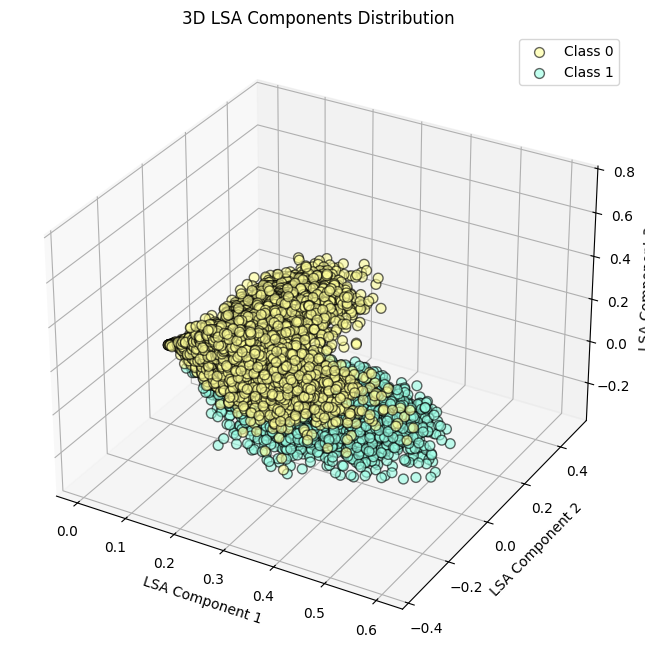

In [12]:
from mpl_toolkits.mplot3d import Axes3D

tfidf = TfidfVectorizer(max_features=3500)
tfidf_matrix = tfidf.fit_transform(corpus['text'])

lsa = TruncatedSVD(n_components=3, random_state=42)
doc_coords = lsa.fit_transform(tfidf_matrix)

labels = corpus['label']

def create_3d_density_plot(doc_coords, labels):
    # Create 3D figure
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    mask0 = labels == 0
    mask1 = labels == 1

    label0_points = doc_coords[mask0]
    label1_points = doc_coords[mask1]

    ax.scatter(
        label0_points[:, 0],
        label0_points[:, 1],
        label0_points[:, 2],
        c='#FFFF99',
        s=50,
        alpha=0.6,
        edgecolors='black',
        label='Class 0'
    )

    ax.scatter(
        label1_points[:, 0],
        label1_points[:, 1],
        label1_points[:, 2],
        c='#99FFE5',
        s=50,
        alpha=0.6,
        edgecolors='black',
        label='Class 1'
    )

    ax.set_xlabel('LSA Component 1')
    ax.set_ylabel('LSA Component 2')
    ax.set_zlabel('LSA Component 3')
    ax.set_title('3D LSA Components Distribution')

    ax.legend()

    ax.set_facecolor('white')
    fig.set_facecolor('white')

    return plt


plt.style.use('default')
plot = create_3d_density_plot(doc_coords, labels)

print("\nLabel Distribution:")
print(corpus['label'].value_counts())

plt.show()

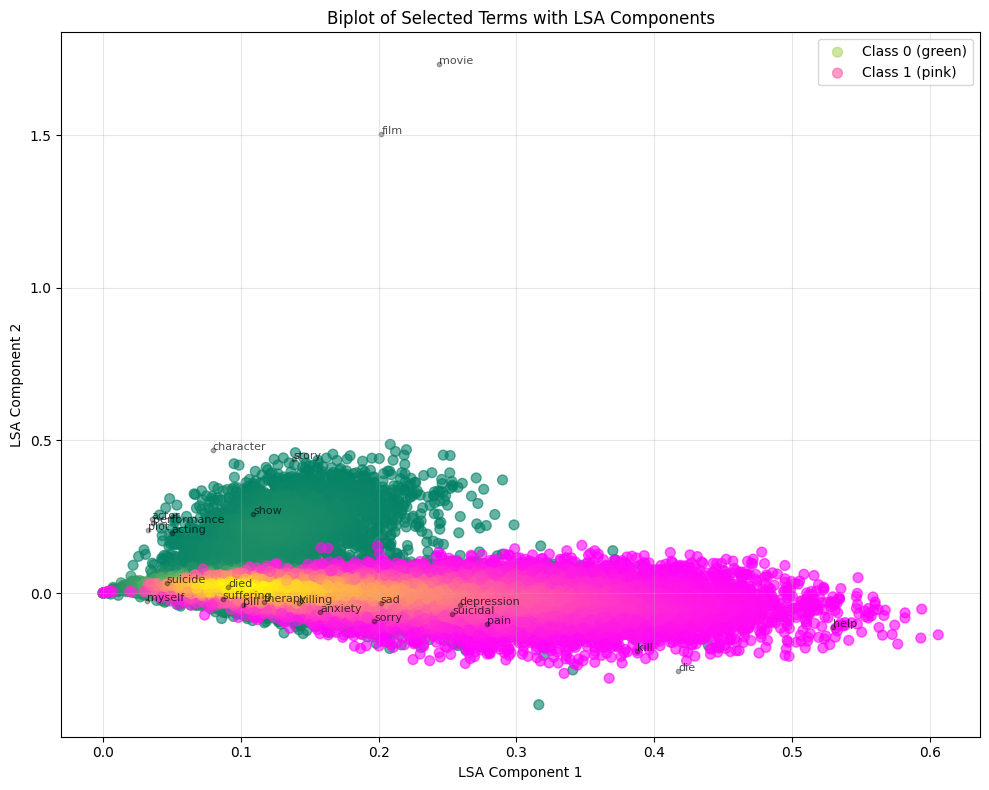


Label Distribution:
label
1    12648
0    10592
Name: count, dtype: int64

Label Centroids:
   Component_1  Component_2
0     0.134474     0.060609
1     0.261488    -0.019996


In [13]:
tfidf = TfidfVectorizer(max_features=3500)
tfidf_matrix = tfidf.fit_transform(corpus['text'])

n_components = 2
lsa = TruncatedSVD(n_components=n_components, random_state=42)
doc_coords = lsa.fit_transform(tfidf_matrix)

term_coords = lsa.components_.T * np.sqrt(lsa.singular_values_)

highlight_terms = ['suicidal', 'depression', 'suicide', 'kill', 'myself', 'die',
                   'died', 'pain', 'sad', 'help', 'sorry', 'anxiety', 'therapy',
                   'suffering', 'killing', 'pill',
                   'movie', 'film', 'character', 'story', 'actor', 'performance', 'show',
                   'plot', 'acting']

terms = tfidf.get_feature_names_out()
highlight_indices = [i for i, term in enumerate(terms) if term in highlight_terms]
highlighted_term_coords = term_coords[highlight_indices]
highlighted_terms = [terms[i] for i in highlight_indices]

def plot_lsa_biplot(doc_coords, term_coords, labels, ax):
    xy = np.vstack([doc_coords[:, 0], doc_coords[:, 1]])
    density = gaussian_kde(xy)(xy)
    density = (density - density.min()) / (density.max() - density.min())

    class_0_mask = labels == 0
    class_1_mask = labels == 1

    scatter_0 = ax.scatter(
        doc_coords[class_0_mask, 0],
        doc_coords[class_0_mask, 1],
        c=density[class_0_mask],
        cmap='summer',
        s=50,
        alpha=0.6,
        label='Class 0 (green)'
    )

    scatter_1 = ax.scatter(
        doc_coords[class_1_mask, 0],
        doc_coords[class_1_mask, 1],
        c=density[class_1_mask],
        cmap='spring',
        s=50,
        alpha=0.6,
        label='Class 1 (pink)'
    )

    for i, term in enumerate(highlighted_terms):
        ax.text(
            highlighted_term_coords[i, 0],
            highlighted_term_coords[i, 1],
            term,
            color='black',
            alpha=0.7,
            fontsize=8
        )
        ax.scatter(
            highlighted_term_coords[i, 0],
            highlighted_term_coords[i, 1],
            color='black',
            alpha=0.3,
            s=10
        )

    ax.legend(loc='upper right')

    ax.set_title('Biplot of Selected Terms with LSA Components')
    ax.set_xlabel('LSA Component 1')
    ax.set_ylabel('LSA Component 2')
    ax.grid(True, alpha=0.3)

fig, ax = plt.subplots(figsize=(10, 8))

plot_lsa_biplot(doc_coords, term_coords, corpus['label'], ax)

plt.tight_layout()
plt.show()

print("\nLabel Distribution:")
print(corpus['label'].value_counts())

def calculate_label_centroids(doc_coords, labels):
    centroids = {}
    for label in labels.unique():
        mask = labels == label
        centroid = doc_coords[mask].mean(axis=0)
        centroids[label] = centroid

    return pd.DataFrame.from_dict(centroids, orient='index',
                                  columns=['Component_1', 'Component_2'])

centroids_df = calculate_label_centroids(doc_coords, corpus['label'])
print("\nLabel Centroids:")
print(centroids_df)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(max_features=3500)
tfidf_matrix = tfidf.fit_transform(corpus['text'])

n_components = 100
lsa = TruncatedSVD(n_components=n_components, random_state=42)
doc_coords = lsa.fit_transform(tfidf_matrix)

print(doc_coords.shape)

term_coords = lsa.components_.T * np.sqrt(lsa.singular_values_)

def analyze_similarities(tfidf, term_coords, doc_coords, corpus, top_n=10):
    term_similarities = cosine_similarity(term_coords)

    feature_names = np.array(tfidf.get_feature_names_out())

    doc_similarities = cosine_similarity(doc_coords)

    def get_top_similar(similarities, items, idx, n=top_n):
        sim_scores = similarities[idx]
        top_indices = np.argsort(sim_scores)[::-1][1:n + 1]

        items_array = np.array(list(items))
        return list(zip(items_array[top_indices], sim_scores[top_indices]))

    interesting_terms = ['suicidal', 'depression', 'suicide', 'kill', 'myself', 'die',
                         'died', 'pain', 'sad', 'help', 'sorry', 'anxiety', 'therapy',
                         'suffering', 'killing', 'pill',
                         'movie', 'film', 'character', 'story', 'actor', 'performance', 'show',
                         'plot', 'acting']
    term_results = {}

    for term in interesting_terms:
        if term in feature_names:
            idx = np.where(feature_names == term)[0][0]
            similar_terms = get_top_similar(term_similarities, feature_names, idx)
            term_results[term] = similar_terms

    sample_docs = [0, 10, 20, 30]
    doc_results = {}

    doc_indices = np.arange(len(corpus))

    for doc_idx in sample_docs:
        similar_docs = get_top_similar(doc_similarities, doc_indices, doc_idx)
        doc_results[doc_idx] = {
            'original': corpus['text'].iloc[doc_idx][:200] + "...",
            'original_label': corpus['label'].iloc[doc_idx],
            'similar': [(corpus['text'].iloc[int(idx)][:200] + "...",
                         corpus['label'].iloc[int(idx)],
                         score)
                        for idx, score in similar_docs]
        }

    return term_results, doc_results


term_results, doc_results = analyze_similarities(tfidf, term_coords, doc_coords, corpus)

print("Similar Terms Analysis:")
print("-" * 50)
for term, similars in term_results.items():
    print(f"\nSimilar terms to '{term}':")
    for similar_term, score in similars:
        print(f"  {similar_term}: {score:.3f}")

print("\nSimilar Documents Analysis:")
print("-" * 50)
for doc_idx, results in doc_results.items():
    print(f"\nOriginal Document {doc_idx} [Class: {results['original_label']}]:")
    print(results['original'])
    print("\nSimilar Documents:")
    for i, (doc, label, score) in enumerate(results['similar'], 1):
        print(f"\n{i}. Similarity Score: {score:.3f} [Class: {label}]")
        print(doc)

### Tóm tắt quá trình LSA
- Ta thấy rằng hầu hết những chủ đề tiềm ẩn này khá khó để có thể hiểu được.
- Tuy nhiên ta có thể sử dụng trực quan để đưa ra các phỏng đoán dựa vào việc phân tích các terms và documents đại diện cho chủ đề đó.
- Bước trên có thể được thông suốt hơn nữa bằng cách sử dụng Cosine Similarity.
- Ngoài ra, thay vì sử dụng Explained Variance để chọn được 1 số chiều tối ưu như với PCA, khi hiểu rằng các chiều của LSA là các chủ đề tiềm ẩn và variance giữa các chủ đề này thường không mang lại nhiều ý nghĩa, thực chất trên tất cả mọi Corpus, lượng chủ đề thường không quá nhiều, chỉ từ 5 - 300 tùy vào độ lớn của Corpus.
- Vì vậy, ta sẽ chỉ chọn số chiều giảm về 100 với 1 phỏng đoán ngây thơ rằng ước tính có 100 chủ đề tiềm ẩn trong cả Corpus khi sử dụng cho việc đánh giá phân loại. Ngoài ra, lựa chọn này cũng để đảm bảo chúng ta không mất quá nhiều thông tin gốc.
- Đơn giản hiểu rằng, chúng ta đang đánh đổi interpretability để sử dụng những chủ đề tiềm ẩn này, do với ma trận TF-IDF gốc, mỗi đặc trưng vẫn là 1 token cụ thể có thể hiểu được.